# Figures for the GODEEEP Transportation Paper


In [112]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable


## Set the Directory Structure


In [94]:
# Identify the top-level directory and the subdirectory where the data will be stored:
ba_data_input_dir =  '/Users/burl878/Documents/IMMM/GODEEP/Data/Merged_BA_Loads/'
tell_data_input_dir =  '/Users/burl878/Documents/IMMM/GODEEP/Data/TELL/Production_Runs/tell_data/outputs/tell_output/'
metadata_input_dir =  '/Users/burl878/Documents/IMMM/GODEEP/Data/state_shapefiles/'
image_output_dir =  '/Users/burl878/Documents/Papers/2023_Acharya_et_al/Figures/'


## Process the BA-Level Transportation Ratio Statistics


In [35]:
# Define a function to compute the load ratios for given year and scenario:
def process_load_ratios(scenario_to_process: str, year_to_process: str, data_input_dir: str):
    
    # Read in the .csv file:
    load_df = pd.read_csv((data_input_dir + 'Total_Load_Time_Series_' + scenario_to_process + '_' + year_to_process + '.csv'))
    
    # Calculate the load ratio (transportation load divided by total load):
    load_df['Load_Ratio'] = (load_df['Transportation_Load_MWh']/load_df['Total_Load_MWh']).round(3)
    
    # Make a list of all of the BAs:
    bas = load_df['BA_Code'].unique()
    
    #Initiate a counter and empty dataframe to store the results:
    counter = 0;
    output_df = pd.DataFrame()
    
    # Loop over the BAs and process their data into an output file:
    for i in range(len(bas)):
        # Iterate the counter by one:
        counter = counter + 1
            
        # Subset to just the data for the BA being processed:
        subset_df = load_df[load_df['BA_Code'].isin([bas[i]])].copy()
        
        # Put the output in a new dataframe:
        output_df.loc[counter, 'BA'] = bas[i]
        output_df.loc[counter, 'System_Energy_Ratio'] = ((subset_df['Transportation_Load_MWh'].sum()) / (subset_df['Total_Load_MWh'].sum())).round(3)
        output_df.loc[counter, 'Peak_System_Ratio'] = subset_df['Load_Ratio'].loc[subset_df['Total_Load_MWh'].idxmax()].round(3)
        output_df.loc[counter, 'Peak_Transportation_Ratio'] = subset_df['Load_Ratio'].loc[subset_df['Transportation_Load_MWh'].idxmax()].round(3)
        
        # Clean up
        del subset_df
            
    return output_df
   

In [4]:
# Test the function for a given year and scenario:
output_df = process_load_ratios(scenario_to_process = 'BAU_Climate',
                                year_to_process = '2035',
                                data_input_dir = ba_data_input_dir)

output_df


,BA,System_Energy_Ratio,Peak_System_Ratio,Peak_Transportation_Ratio
1,AVA,0.066,0.068,0.080
2,AZPS,0.161,0.127,0.150
3,BANC,0.113,0.080,0.092
4,BPAT,0.080,0.068,0.091
5,CHPD,0.080,0.046,0.060
6,CISO,0.111,0.093,0.117
7,DOPD,0.048,0.038,0.081
8,EPE,0.057,0.034,0.099
9,GCPD,0.028,0.021,0.032
10,IID,0.461,0.384,0.423


## Plot the BA-Level Transportation Ratio Statistics


In [28]:
# Define a function to plot the load ratios for given year and scenario:
def plot_load_ratios(scenario_to_plot: str, year_to_plot: str, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    if scenario_to_plot == 'BAU_Climate':
       scenario_label = 'Business as Usual'
    if scenario_to_plot == 'NetZeroNoCCS_Climate':
       scenario_label = 'Net Zero'
    
    # Process the data:
    plot_df = process_load_ratios(scenario_to_process = scenario_to_plot,
                                  year_to_process = year_to_plot,
                                  data_input_dir = ba_data_input_dir)
    
    # Create an x-axis the length of the dataframe to be used in plotting:
    x_axis = np.arange(len(plot_df))
    
    # Make the plot:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 16
    
    plt.bar(x_axis - 0.25, plot_df['Peak_System_Ratio'], 0.25, label=('Ratio of transportation load to system load at system peak'))
    plt.bar(x_axis, plot_df['Peak_Transportation_Ratio'], 0.25, label=('Ratio of transportation load to system load at transportation peak'))
    plt.bar(x_axis + 0.25, plot_df['System_Energy_Ratio'], 0.25, label=('Ratio of yearly transportation energy to system energy'))
    plt.xticks(x_axis, plot_df['BA'])
    plt.xticks(rotation=25)
    plt.xlim([0.4, 27.6])
    plt.xlabel('Balancing Authority')
    #plt.ylim([0, 1])
    plt.legend()
    plt.ylabel('Ratio')
    plt.grid(False)
    plt.title(('Comparison of Transportation to System Loads: ' + scenario_label + ', ' + year_to_plot))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('Transportation_Load_Ratios_' + scenario_to_plot + '_' + year_to_plot + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
    

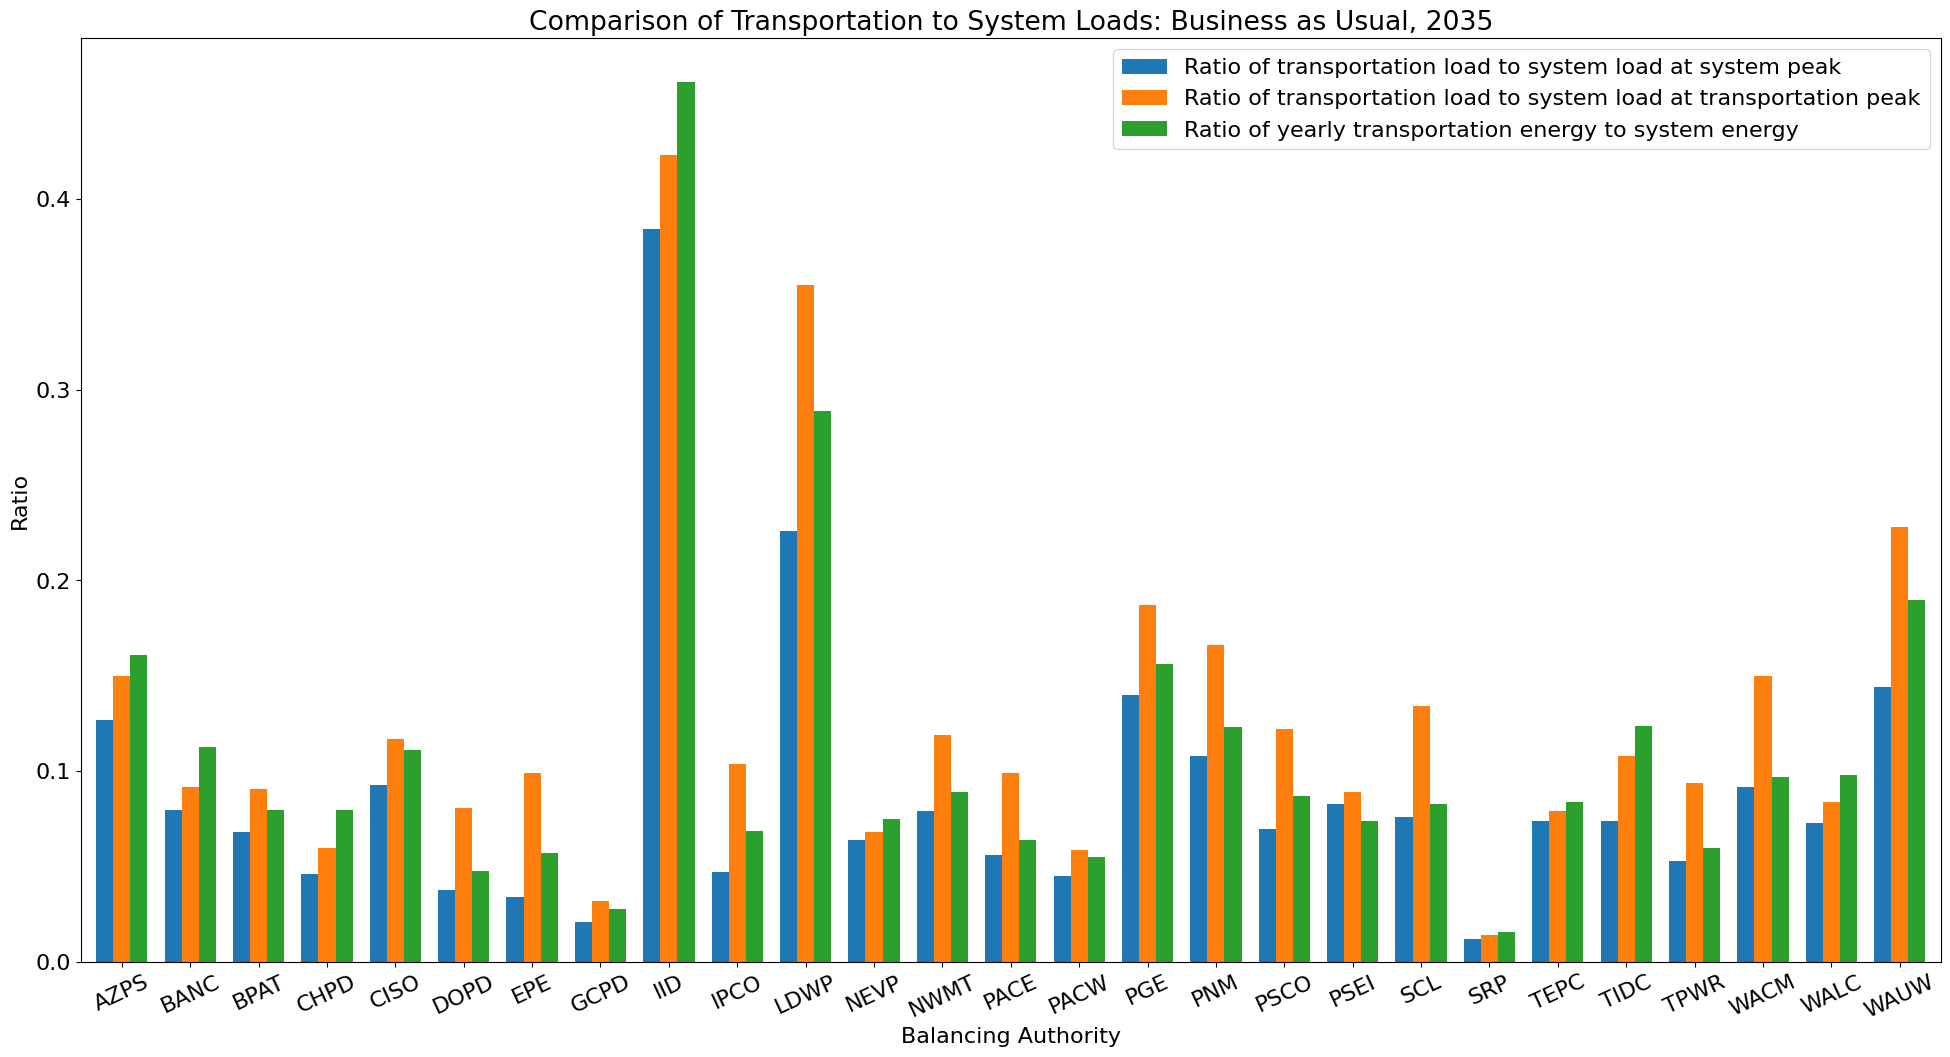

In [33]:
# Make the plot for a given year and scenario:
plot_load_ratios(scenario_to_plot = 'BAU_Climate',
                 year_to_plot = '2035',
                 data_input_dir = ba_data_input_dir,
                 image_output_dir = image_output_dir, 
                 image_resolution = 300, 
                 save_images = True)


## Process and Plot the State-Level Transportation and Total Load Data


In [165]:
# Define a function to merge the state-level load ratios
def plot_state_loads(scenario_to_plot: str, year_to_plot: str, tell_data_input_dir: str, metadata_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
            
    # Read in the state output files for tell, subset to just the columns we need, and rename the columns for consistency:
    load_df = pd.read_csv((tell_data_input_dir + '/' + scenario_to_plot + '/' + year_to_plot + '/TELL_State_Summary_Data_' + year_to_plot + '_Scaled_' + year_to_plot + '.csv'))
    
    # Rename a few columns:
    load_df.rename(columns={'State_Name': 'State',
                            'GCAM_USA_Non_Transportation_Load_TWh': 'NonTransportation_TWh',
                            'GCAM_USA_Transportation_Load_TWh': 'Transportation_TWh'}, inplace=True)
    
    # Compute the total load and the load ratios:
    load_df['Total_TWh'] = load_df['NonTransportation_TWh'] + load_df['Transportation_TWh']
    load_df['Transportation_Fraction'] = (load_df['Transportation_TWh']/load_df['Total_TWh']).round(3)
    
    # Only keep the columns we need:
    load_df = load_df[['State', 'NonTransportation_TWh', 'Transportation_TWh', 'Total_TWh', 'Transportation_Fraction']].copy()
    
    # Read in the county shapefile and reassign the 'FIPS' variable as integers:
    states_df = gpd.read_file(os.path.join(metadata_input_dir, 'tl_2022_us_state.shp')).rename(columns={'NAME': 'State'})
    
    # Merge the subset_df and states_df together using state names to join them:
    plot_df = states_df.merge(load_df, on='State', how='left')    
    
    # Subset to just the states in the WECC:
    plot_df = plot_df[plot_df['State'].isin(['Arizona', 'California', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming'])]
    
    if scenario_to_plot == 'BAU_Climate':
       scenario_label = 'Business as Usual'
    if scenario_to_plot == 'NetZeroNoCCS_Climate':
       scenario_label = 'Net Zero'
    
    # Set the colormap and color limits:
    colors = plt.get_cmap('RdYlBu_r', 20)
    min_value = 0
    max_value = 0.5
    
    # Make the map plot:
    fig, ax = plt.subplots(1, 1, figsize=(24, 12))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.01)
    plot_df.plot(ax=ax, cax=cax, column='Transportation_Fraction', cmap=colors, vmin=min_value, vmax=max_value, edgecolor='k', linewidth=2, 
                 legend=True, legend_kwds={'label': ('Ratio of Yearly Transportation Energy to System Energy'), 'orientation': 'vertical'})
    ax.set_title(('Transportation Load Ratios: ' + scenario_label + ', ' + year_to_plot), fontsize = 21)
    ax.set_xlim(-126, -101.2)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylim(31, 49.5)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('State_Load_Ratios_' + scenario_to_plot + '_' + year_to_plot + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
        

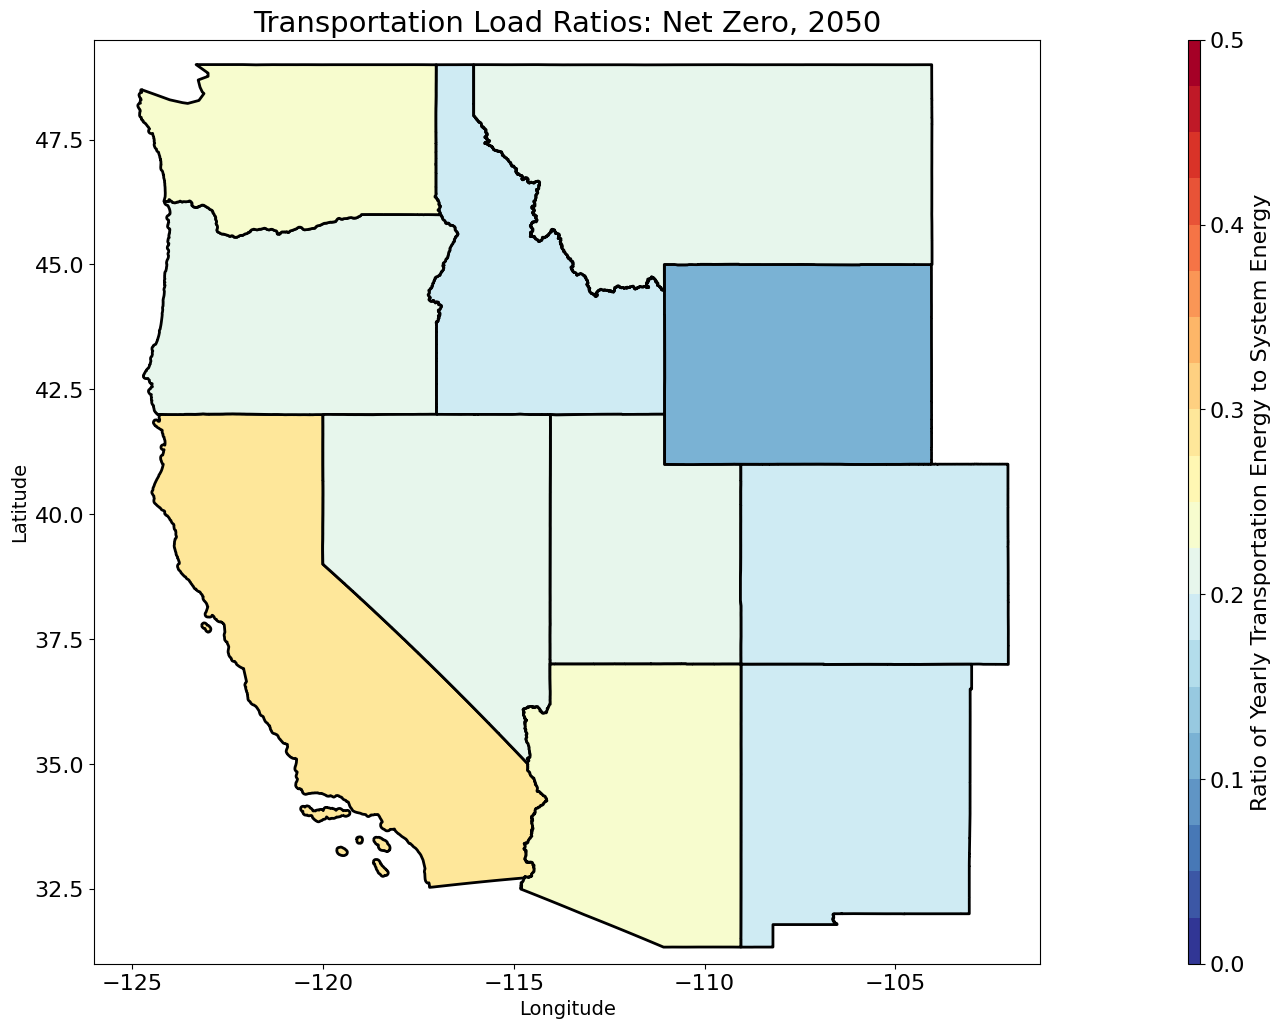

In [169]:
# Make the plot for a given year and scenario:
plot_state_loads(scenario_to_plot = 'NetZeroNoCCS_Climate',
                 year_to_plot = '2050',
                 tell_data_input_dir = tell_data_input_dir,
                 metadata_input_dir = metadata_input_dir,
                 image_output_dir = image_output_dir, 
                 image_resolution = 300, 
                 save_images = True)
